In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from tqdm import tqdm_notebook
progress = tqdm_notebook()

RAW_DATA_DIR = '../data/raw/'
CLEAN_DATA_DIR = '../data/clean/'

A Jupyter Widget

In [2]:
flagged = pd.read_csv(RAW_DATA_DIR+'400k_flag_v2.csv')
flagged.head()

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,patient_id,htn_flag,chf_flag,esrd_flag,copd_flag,dprn_flag,hlpd_flag,malig_flag,smoke_flag,ckd_flag,cad_flag,lbp_flag,thyroid_flag,osa_flag,asthma_flag,t1dm_flag,bariatric_surgery_cpt_flag,amputation_cpt_flag
0,10000073,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10000321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10000420,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10000933,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10001162,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Import and process data


### Demographics

In [3]:
demographics_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_Demographics_20170116.csv', 
                               index_col=0, parse_dates=['DOB'], infer_datetime_format=True)
demographics_raw.head()

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEX,RACE,ETHNICITY,DOB,DOD,ZIP_CODE
MRN,,,,,,
28997286,2,7,UN,1958-01-09,NaN,422100000
22710289,2,2,NH,1969-09-11,NaN,370640000
15333065,1,1,NH,1996-12-28,NaN,372060000
11732831,1,2,NH,1991-01-31,NaN,370400000
26724542,2,1,NH,1958-08-19,NaN,421340000


In [4]:
demographics_raw.shape

(529428, 6)

In [5]:
demographics_raw.index.is_unique

True

Recode categorical variables to something useful

In [6]:
demographics_raw['male'] = (demographics_raw.SEX==1).astype(int)

In [7]:
demographics_raw['race'] = demographics_raw.RACE.replace(dict(zip(range(1, 8), ['white', 'black', 'native', 'asian', 
                                                     'hispanic', 'other', 'unknown'])))

In [8]:
demographics_raw.race.value_counts()

white       419554
black        52455
unknown      32724
hispanic     13540
asian         9708
other          729
native         718
Name: race, dtype: int64

In [9]:
demographics_raw.ETHNICITY.value_counts()

NH    450556
UN     65332
HL     13540
Name: ETHNICITY, dtype: int64

In [10]:
demographics_raw['hispanic'] = (demographics_raw.ETHNICITY=='HL')
demographics_raw.loc[demographics_raw.ETHNICITY=='UN', 'hispanic'] = np.nan

There are no non-null death dates.

In [11]:
demographics_raw.isnull().mean()

SEX          0.000000
RACE         0.000000
ETHNICITY    0.000000
DOB          0.000000
DOD          1.000000
ZIP_CODE     0.001067
male         0.000000
race         0.000000
hispanic     0.123401
dtype: float64

Drop date of death and ethnicity

In [12]:
demographics = demographics_raw.drop(['DOD', 'ETHNICITY'], axis=1)

In [13]:
demographics.shape

(529428, 7)

### Patient flags

In [14]:
flags = pd.read_csv(RAW_DATA_DIR + '400k_flag_v2.csv', index_col=0)
flags.head()

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,htn_flag,chf_flag,esrd_flag,copd_flag,dprn_flag,hlpd_flag,malig_flag,smoke_flag,ckd_flag,cad_flag,lbp_flag,thyroid_flag,osa_flag,asthma_flag,t1dm_flag,bariatric_surgery_cpt_flag,amputation_cpt_flag
patient_id,,,,,,,,,,,,,,,,,
10000073,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10000321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10000420,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10000933,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10001162,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
flagged_demographics = demographics.join(flags)
flagged_demographics.shape

(529428, 24)

### Height measurements

Perhaps choose modal or median for each patient.

In [16]:
height_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_Height_20170213.csv', 
                         parse_dates=[1], infer_datetime_format=True)
height_raw.head()

,MRN,HEIGHT_DATE,HEIGHT
0,1887330,2016-02-22,157.48
1,1887330,2012-01-17,162.56
2,1887330,2013-02-15,162.56
3,1887330,2013-05-17,162.56
4,1887330,2013-08-07,162.56


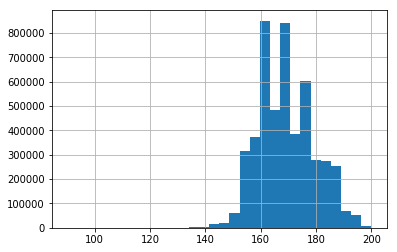

In [17]:
plt.figure()
height_raw.HEIGHT[(height_raw.HEIGHT<200) & (height_raw.HEIGHT>0) ].hist(bins=30)

### Weight data

In [18]:
weight_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_weight_20170213.csv', 
                         parse_dates=[1], infer_datetime_format=True)
weight_raw.head()

,MRN,WEIGHT_DATE,WEIGHT,PREGNANCY_INDICATOR
0,7695679,2006-01-27,62.60,1
1,7695679,2006-02-08,62.60,1
2,7695679,2006-02-08,62.60,1
3,7695679,2006-03-08,63.96,1
4,7695679,2006-10-02,65.77,1


Only take individuals with 5 or more observations

In [19]:
weights_nonpreg = weight_raw[weight_raw.PREGNANCY_INDICATOR==0].drop('PREGNANCY_INDICATOR', axis=1)

In [20]:
weight_counts = weights_nonpreg.groupby('MRN')['WEIGHT_DATE'].count()

In [21]:
MIN_MEASUREMENTS = 5
min_weights = weight_counts[weight_counts>=MIN_MEASUREMENTS].index.values

In [22]:
filtered_weights = weights_nonpreg[weights_nonpreg.MRN.isin(min_weights)]

In [23]:
assert not filtered_weights.isnull().sum().any()

Apply Greevy flagging algorihtm

In [24]:
from scipy.stats import chi2

def calc_concordance(patient, m=-0.032, sd=3.52):
    p = []
    nobs = 11
    for i,x in patient.iterrows():

        # Calculate deltas
        df = (pd.DataFrame({'uid':i, 
                           'delta_W':patient.WEIGHT - x.WEIGHT, 
                           'delta_T':(patient.WEIGHT_DATE - x.WEIGHT_DATE).dt.days.abs()})
             .sort_values('delta_T')[1:nobs] 
             .assign(measurement=np.arange(1, nobs), weight_date=x.WEIGHT_DATE)) 

        # Calculate statistic
        prob = 1 - chi2.cdf(((df.delta_W - m)/sd) ** 2, 1) 

        # Convert to concordance probability
        p.append({'uid':i, 'p':prob.mean()})


    return pd.DataFrame(p).set_index('uid')


In [25]:
recalculate_weights = False

if recalculate_weights:
    progress.pandas(desc='concordance probability calculation')
    concordance = (filtered_weights.groupby('MRN')
                   .progress_apply(calc_concordance))
    concordance.to_csv(CLEAN_DATA_DIR+'concordance.csv')
    # Add a relative date (to first measurement) of each measurement
    concordance.index = concordance.index.droplevel('MRN')
else:
    concordance = pd.read_csv(CLEAN_DATA_DIR+'concordance.csv', index_col=0)

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [26]:
(concordance.p<0.01).mean()

0.0047287468770074569

Proportion excluded as a function of concordance threshold.

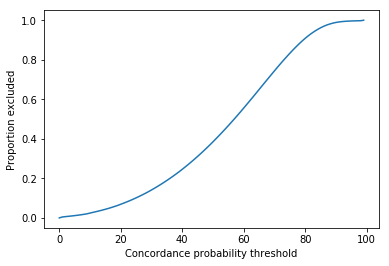

In [27]:
plt.figure()
plt.plot([(concordance.p<p).mean() for p in np.linspace(0, 1, 100)])
plt.xlabel('Concordance probability threshold')
plt.ylabel('Proportion excluded');

Merge concordance probabilities

In [28]:
weights = filtered_weights.join(concordance)

In [29]:
weights['Weight_filtered'] = weights.WEIGHT.copy()
weights.loc[weights.p<0.05, 'Weight_filtered'] = np.nan

In [30]:
len(set(weight_raw.MRN))

526996

Add age to each measurement

In [31]:
weights = weights.merge(demographics[['DOB']], left_on='MRN', right_index=True)
weights['AGE'] = (weights.WEIGHT_DATE - weights.DOB).astype('<m8[Y]')

Calculate BMI

In [32]:
bmi = weights.merge(height_raw, left_on=['MRN', 'WEIGHT_DATE'], 
              right_on=['MRN', 'HEIGHT_DATE'])
bmi['BMI'] = bmi.Weight_filtered / (bmi.HEIGHT / 100)**2

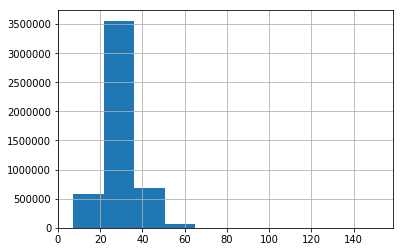

In [33]:
bmi.BMI.hist()

In [34]:
#bmi.to_csv(CLEAN_DATA_DIR+'bmi.csv')

In [35]:
bmi.head()

,MRN,WEIGHT_DATE,WEIGHT,uid,p,Weight_filtered,DOB,AGE,HEIGHT_DATE,HEIGHT,BMI
0,1829209,2012-06-25,67.77,NaN,NaN,67.77,1928-03-01,84.0,2012-06-25,149.86,30.176303
1,1829209,2013-02-28,68.04,NaN,NaN,68.04,1928-03-01,84.0,2013-02-28,152.40,29.295059
2,2618890,2010-08-05,82.55,NaN,NaN,82.55,1942-12-16,67.0,2010-08-05,170.18,28.503621
3,2618890,2015-08-11,83.01,NaN,NaN,83.01,1942-12-16,72.0,2015-08-11,172.72,27.825640
4,2618890,2016-09-06,83.91,NaN,NaN,83.91,1942-12-16,73.0,2016-09-06,172.72,28.127327


Generate subset of patients whose initial BMI is between 27 and 30

In [36]:
def initial_bmi(patient):
    return patient.BMI[patient.WEIGHT_DATE==patient.WEIGHT_DATE.min()].mean()

progress.pandas(desc='relative date calculation')

initial_bmi = bmi.groupby('MRN').progress_apply(initial_bmi)

In [38]:
init_range = initial_bmi[(initial_bmi>=27) & (initial_bmi<=30)].index.values

In [39]:
bmi_init_range = bmi[bmi.MRN.isin(init_range)]
bmi_init_range.MRN.unique().shape

(61158,)

Pivot table of weight by date and patient

In [40]:
bmi_init_range.head()

,MRN,WEIGHT_DATE,WEIGHT,uid,p,Weight_filtered,DOB,AGE,HEIGHT_DATE,HEIGHT,BMI
2,2618890,2010-08-05,82.55,NaN,NaN,82.55,1942-12-16,67.0,2010-08-05,170.18,28.503621
3,2618890,2015-08-11,83.01,NaN,NaN,83.01,1942-12-16,72.0,2015-08-11,172.72,27.825640
4,2618890,2016-09-06,83.91,NaN,NaN,83.91,1942-12-16,73.0,2016-09-06,172.72,28.127327
5,2618890,2012-06-08,85.28,NaN,NaN,85.28,1942-12-16,69.0,2012-06-08,172.72,28.586562
6,2618890,2014-04-04,85.28,NaN,NaN,85.28,1942-12-16,71.0,2014-04-04,172.72,28.586562


In [54]:
def calc_rel_date(patient):
    return patient.WEIGHT_DATE - patient.WEIGHT_DATE.min()


progress.pandas(desc='relative date calculation')

relative_date = bmi_init_range.groupby('MRN').progress_apply(calc_rel_date)    

A Jupyter Widget

In [56]:
bmi_init_range[bmi_init_range.MRNN==76216]

,MRN,WEIGHT_DATE,WEIGHT,uid,p,Weight_filtered,DOB,AGE,HEIGHT_DATE,HEIGHT,BMI
806970,76216,2014-03-21,55.14,NaN,NaN,55.14,1936-01-18,78.0,2014-03-21,160.02,21.533679
806971,76216,2014-03-21,55.34,NaN,NaN,55.34,1936-01-18,78.0,2014-03-21,160.02,21.611784
806972,76216,2014-07-02,59.11,NaN,NaN,59.11,1936-01-18,78.0,2014-07-02,160.02,23.084072
806973,76216,2013-09-24,60.41,NaN,NaN,60.41,1936-01-18,77.0,2013-09-24,160.02,23.591758
806974,76216,2013-09-12,62.62,NaN,NaN,62.62,1936-01-18,77.0,2013-09-12,160.02,24.454823
806975,76216,2013-08-27,63.64,NaN,NaN,63.64,1936-01-18,77.0,2013-08-27,160.02,24.853161
806976,76216,2013-08-06,64.47,NaN,NaN,64.47,1936-01-18,77.0,2013-08-06,160.02,25.177299
806977,76216,2013-07-09,64.64,NaN,NaN,64.64,1936-01-18,77.0,2013-07-09,160.02,25.243689
806978,76216,2011-05-20,65.77,NaN,NaN,65.77,1936-01-18,75.0,2011-05-20,160.02,25.684985
806979,76216,2009-05-14,66.22,NaN,NaN,66.22,1936-01-18,73.0,2009-05-14,155.58,27.357830


In [55]:
relative_date

MRN              
76216     806970    1772 days
          806971    1772 days
          806972    1875 days
          806973    1594 days
          806974    1582 days
          806975    1566 days
          806976    1545 days
          806977    1517 days
          806978     736 days
          806979       0 days
          806980     904 days
          806981     351 days
599811    546471    3324 days
          546472    3268 days
          546473    3185 days
          546474    3372 days
          546475    3116 days
          546476    3088 days
          546477    3620 days
          546478    3555 days
          546479    3577 days
          546480    3577 days
          546481    3683 days
          546482    3743 days
          546483    3766 days
          546484    3766 days
          546485    3001 days
          546486    3750 days
          546487    2913 days
          546488    2833 days
                       ...   
95657524  3992853   1054 days
          3992854     

In [50]:
bmi_by_patient = pd.pivot_table(bmi_init_range, 
                                    index='WEIGHT_DATE', columns='MRN', values='BMI').resample('W').median()

In [51]:
bmi_by_patient.head()

MRN,76216,599811,626192,661561,667436,763185,946012,1056605,1058304,1115302,...,41321662,95519682,95657524,95838280,96054903,96060140,96082086,96413166,96624150,96891189
WEIGHT_DATE,,,,,,,,,,,,,,,,,,,,,
2001-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
bmi_by_patient.index.min(), bmi_by_patient.index.max()

(Timestamp('2001-07-29 00:00:00', freq='2W-SUN'),
 Timestamp('2017-01-08 00:00:00', freq='2W-SUN'))

In [45]:
year = bmi_by_patient.reset_index().WEIGHT_DATE.dt.year
week = bmi_by_patient.reset_index().WEIGHT_DATE.dt.week

In [46]:
bmi_by_patient['year'] = year.values
bmi_by_patient['week'] = week.values

In [48]:
bmi_by_patient.head()

MRN,76216,599811,626192,661561,667436,763185,946012,1056605,1058304,1115302,...,95657524,95838280,96054903,96060140,96082086,96413166,96624150,96891189,year,week
WEIGHT_DATE,,,,,,,,,,,,,,,,,,,,,
2001-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001,30
2001-08-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001,32
2001-08-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001,34
2001-09-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001,36
2001-09-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001,38


In [49]:
ind = (bmi_by_patient.index >= '2002-01-01') & (bmi_by_patient.index < '2003-07-01')
interval = bmi_by_patient[ind].copy()
interval.loc[interval.year == (2003), 'week'] = interval.loc[interval.year == (2003), 'week'] + 52
first_year = interval[interval.year == 2002].drop('year', axis=1)
first_year.dropna(axis=1, thresh=1)

MRN,667436,1130277,1298975,1582865,2186450,2192136,2468080,2577328,2797207,2884070,...,21167358,21195706,21202791,21208467,21210844,21215736,21218193,21224639,21232582,week
WEIGHT_DATE,,,,,,,,,,,,,,,,,,,,,
2002-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2002-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2002-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
2002-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
2002-03-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
2002-03-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
2002-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
2002-04-21,NaN,NaN,NaN,NaN,29.743767,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
2002-05-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18


In [ ]:
intervals = []

MIN_OBS = 5

for y in range(2002, 2016):
    
    ind = (bmi_by_patient.index >= '%i-01-01' % y) & (bmi_by_patient.index < '%i-07-01' % (y+1))
    interval = bmi_by_patient[ind].copy()
    # 18-month week column
    interval.loc[interval.year == (y+1), 'week'] = interval.loc[interval.year == (y+1), 'week'] + 52
    # Drop those without MIN_OBS observations in 18 month period
    intervals.append(interval.dropna(axis=1, thresh=MIN_OBS)
                            .reset_index(drop=True)
                             .set_index('week')
                             .drop('year', axis=1)
                             .iloc[:39])

In [ ]:
bmi_18_month = pd.concat([i.set_index(intervals[0].index) for i in intervals], axis=1)

Here is a random 20 trajectories

In [ ]:
axes = (bmi_18_month[np.random.choice(bmi_18_month.columns, 20)]
#                     .interpolate(limit=10)
                    .plot(legend=False, alpha=0.3))
axes.set_ylabel('BMI');

In [ ]:
bmi_18_month.to_csv(CLEAN_DATA_DIR+'bmi_18_month.csv')

In [ ]:
bmi_18_month.shape

### Lab values

In [42]:
lab_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_Lab_20170213.csv', 
                      usecols = ['MRN','LAB_DATE','LAB_VALUE','LAB_NAME','LAB_UNIT'],
                      parse_dates=[1], infer_datetime_format=True)
lab_raw.head()

,MRN,LAB_DATE,LAB_VALUE,LAB_NAME,LAB_UNIT
0,2156149,10/09/2013,1.09,Creat,mg/dL
1,2156149,10/09/2013,1.04,Creat,mg/dL
2,2156149,10/09/2013,0.89,Creat,mg/dL
3,2156149,10/10/2013,0.89,Creat,mg/dL
4,2156149,10/10/2013,0.97,Creat,mg/dL


In [43]:
lab_raw.shape

(8496974, 5)

### ICD codes

In [44]:
icd_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_ICD_9_10_20170116.csv', 
                      parse_dates=[1], infer_datetime_format=True)
icd_raw.head()

,MRN,EVENT_DATE,ICD_CODE,CODE_TYPE
0,2360139,2003-01-07,401.1,9
1,2360139,2002-01-08,401.1,9
2,2360139,2003-01-08,401.1,9
3,2360139,2005-01-11,401.1,9
4,2360139,2004-01-13,401.9,9


In [45]:
icd_raw.shape

(8796137, 4)

In [46]:
icd_raw.CODE_TYPE.value_counts()


9     7098563
10    1697574
Name: CODE_TYPE, dtype: int64

### CPT codes

In [51]:
cpt_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_CPT_20170116.csv',
                     parse_dates=[1], infer_datetime_format=True)
cpt_raw.head()

,MRN,CPT_DATE,CPT_CODE
0,31275076,2012-05-29,43775
1,31275076,2012-05-29,43775
2,31275076,2012-05-29,43775
3,31275076,2012-05-29,43775
4,31275076,2012-05-29,43775


In [52]:
cpt_raw.isnull().mean()


MRN         0.0
CPT_DATE    0.0
CPT_CODE    0.0
dtype: float64

In [53]:
demographics_raw.merge(cpt_raw, left_index=True, right_on='MRN', how='inner').shape

(65769, 12)